In [1]:
import get_data as get_data
import load_data as load

import pandas as pd
import seaborn as sns
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [3]:
def wilder_smooth(value_list, period):
    nan_offset = np.isnan(value_list).sum()
    smoothened = [np.nan for i in range(period-1+nan_offset)]
    smoothened.append(np.mean(value_list[nan_offset:period+nan_offset]))
    for i in range(period+nan_offset, len(value_list)):
        smoothened.append(smoothened[i-1] + (value_list[i] - smoothened[i-1]) / period)
    return np.array(smoothened)


def ma_rel_diff(df, period=50):
    df['ma_rel_diff_{}'.format(period)] = 1 - df['close'].rolling(period).mean().values / df['close']
    return df


def ema_rel_diff(df, period=10):
    df['ema_rel_diff_{}'.format(period)] = 1 - df['close'].ewm(span=period, min_periods=period-1).mean().values / df['close']
    return df


def mom(df, period=20):
    df['moment_{}'.format(period)] = df['close'].diff(period).values
    return df


def roc(df, period=14):
    df['roc_{}'.format(period)] = df['close'] / df['close'].shift(period).values
    return df


def bbands(df, period=20, std_off=2):
    boil_mean = df['close'].rolling(period).mean().to_frame(name='boil_mean_{}_{}'.format(period, std_off))
    boil_std = df['close'].rolling(period).std().to_frame(name='boil_std_{}_{}'.format(period, std_off))

    boil_up = (boil_mean['boil_mean_{}_{}'.format(period, std_off)] + std_off*boil_std['boil_std_{}_{}'.format(period, std_off)]).to_frame(name='boil_up_{}_{}'.format(period, std_off))
    boil_down = (boil_mean['boil_mean_{}_{}'.format(period, std_off)] - std_off*boil_std['boil_std_{}_{}'.format(period, std_off)]).to_frame(name='boil_down_{}_{}'.format(period, std_off))

    df = df.join(boil_mean)
    df = df.join(boil_up)
    df = df.join(boil_down)

    return df

def normalized_bbands(df, period=20, std_off=20):
    boil_mean = df['close'].rolling(period).mean()
    boil_std = df['close'].rolling(period).std()

    boil_up = df['close'].values / (boil_mean + std_off*boil_std) - 1
    boil_down = df['close'].values / (boil_mean - std_off*boil_std) - 1

    boil_up = boil_up * boil_up.gt(0)
    boil_down = boil_down * boil_down.lt(0)

    df['normBB'] = boil_up.values + boil_down.values

    return df


def rsi(df, period=14):
    df['rsi_{}'.format(period)] = 100.0 - 100.0 / (1.0 + df['close'].diff(1).gt(0).rolling(period).mean().values / df['close'].diff(1).lt(0).rolling(period).mean().values)
    return df


def stochastics(df, period=14, smooth=3):
    stoch_k = (100.0 * (df['close'] - df['low'].rolling(period).min()) / (df['high'].rolling(period).max() - df['low'].rolling(period).min())).to_frame(name='stoch_k_{}'.format(period))
    stoch_d = stoch_k['stoch_k_{}'.format(period)].rolling(smooth).mean().to_frame(name='stoch_d_{}_{}'.format(period, smooth))
    df = df.join(stoch_d)

    return df


def macd(df, period_fast=12, period_slow=26, smooth=9):
    macd = df['close'].ewm(span=period_fast, min_periods=period_fast-1).mean() - df['close'].ewm(span=period_slow, min_periods=period_slow-1).mean()
    macd_smoothed = macd.ewm(span=smooth, min_periods=smooth-1).mean().values

    df['macd_{}_{}_{}'.format(period_fast, period_slow, smooth)] = macd - macd_smoothed

    return df


def atr(df, period=14):
    TR = pd.concat([df['high'], df['close'].shift(1)], 1).max(1) - pd.concat([df['low'], df['close'].shift(1)], 1).min(1)
    ATR = TR.rolling(period).mean().to_frame(name='atr_{}'.format(period))
    return df.join(ATR)


def adx(df, period=14):
    TR = pd.concat([df['high'], df['close'].shift(1)], 1).max(1) - pd.concat([df['low'], df['close'].shift(1)], 1).min(1)
    df['ATR'] = wilder_smooth(TR, period)

    up_down = df['high'].diff(1).gt(-1*df['low'].diff(1))

    pDM = df['high'].diff(1) * df['high'].diff(1).gt(0) * up_down
    mDM = df['low'].diff(1) * df['low'].diff(1).lt(0) * (up_down - 1)

    pDI = 100 * wilder_smooth(pDM.values, period) / df['ATR']
    mDI = 100 * wilder_smooth(mDM.values, period) / df['ATR']

    DX = (100 * (pDI - mDI).abs() / (pDI + mDI))

    ADX = pd.DataFrame(wilder_smooth(DX, period), index=df.index, columns=['adx_{}'.format(period)])

    return df.join(ADX)


In [4]:
df = get_data.get_data_frame()


df.describe()


open        close          low         high        volume  \
count   721.000000   721.000000   721.000000   721.000000  7.210000e+02   
mean    836.970265   840.717421   810.408735   862.368623  6.122744e+06   
std     656.581738   660.580427   623.765702   685.202494  1.519528e+07   
min     191.300000   178.719313   174.570134   219.990000  2.779902e+01   
25%     418.590000   418.800000   413.000000   425.701818  2.008052e+04   
50%     613.058970   613.058970   608.000000   620.600000  2.211959e+05   
75%     996.500000   998.800000   957.673528  1019.000000  1.936981e+06   
max    2937.100000  2937.100000  2784.000000  2977.000000  1.159965e+08   

         adj_close  
count   721.000000  
mean    837.113443  
std     654.752371  
min     207.450144  
25%     419.095216  
50%     613.941613  
75%     999.399799  
max    2876.032965

In [5]:
df.tail()

open        close          low         high        volume  \
716  2753.486099  2855.000000  2692.174171  2883.000000  2.935339e+07   
717  2855.000000  2736.482685  2640.000000  2927.000000  5.205698e+07   
718  2736.382685  2699.000000  2667.660626  2760.468132  2.371465e+07   
719  2699.000000  2794.890000  2698.000000  2808.770599  1.533955e+07   
720  2789.120000  2863.009999  2762.000000  2879.900000  1.735907e+07   

           date    adj_close  exchange      pair  
716  2017-07-31  2790.199984  poloniex  USDT_BTC  
717  2017-08-01  2768.342377  poloniex  USDT_BTC  
718  2017-08-02  2716.167314  poloniex  USDT_BTC  
719  2017-08-03  2754.093737  poloniex  USDT_BTC  
720  2017-08-04  2832.349043  poloniex  USDT_BTC

In [6]:
df.index  = df.date
df = df[[ 'open','close','low','high','volume']]



In [7]:
df = ma_rel_diff(df)
df = ema_rel_diff(df)
df = mom(df)
df = roc(df)
df = bbands(df)
df = normalized_bbands(df)
df = rsi(df)
df = stochastics(df)
df = macd(df)
df = atr(df)
df = adx(df)

In [8]:
df = df.dropna()

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

sc = scaler.fit_transform(df)


In [10]:
    col = ['open', 'low', 'high', 'volume', 'ma_rel_diff_50',
           'ema_rel_diff_10', 'moment_20', 'roc_14', 'boil_mean_20_2',
           'boil_up_20_2', 'boil_down_20_2', 'normBB', 'rsi_14', 'stoch_d_14_3',
           'macd_12_26_9', 'atr_14', 'ATR', 'adx_14']

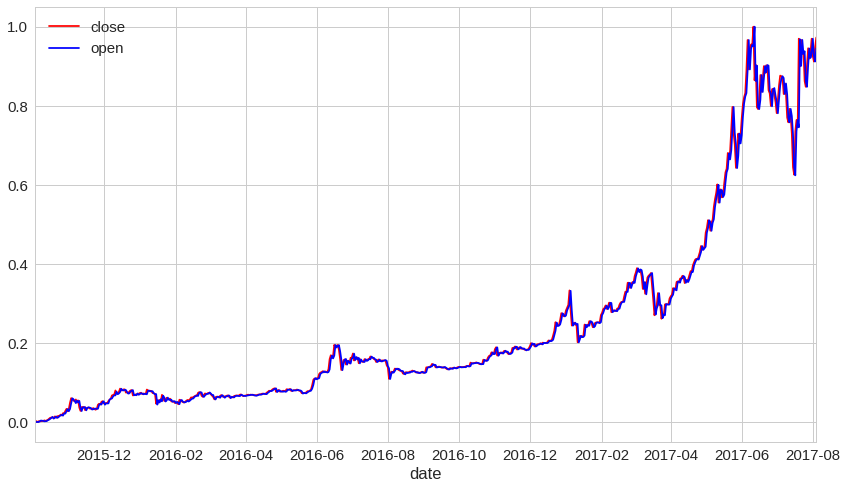

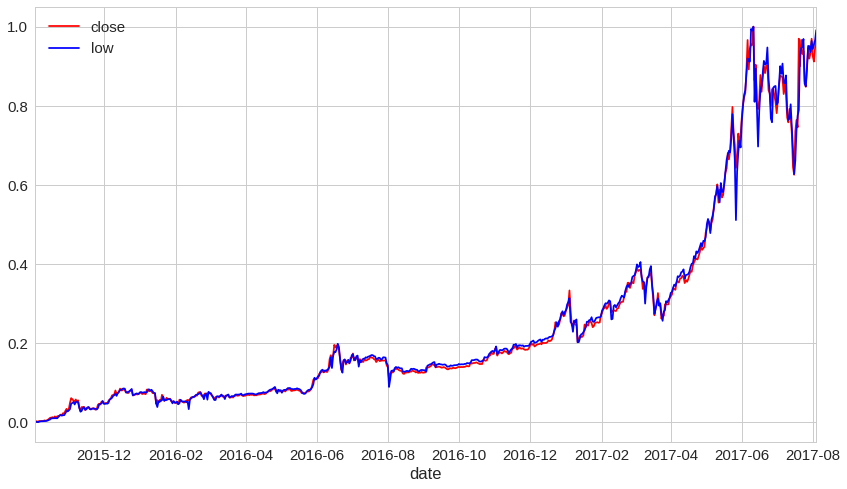

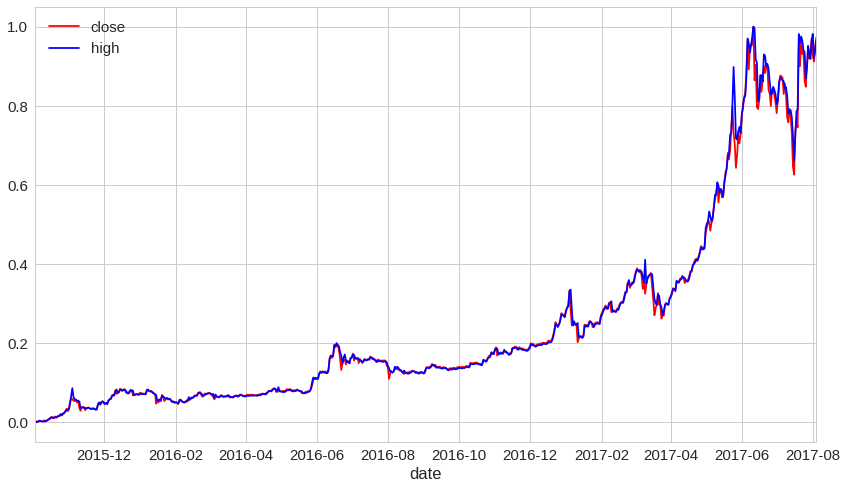

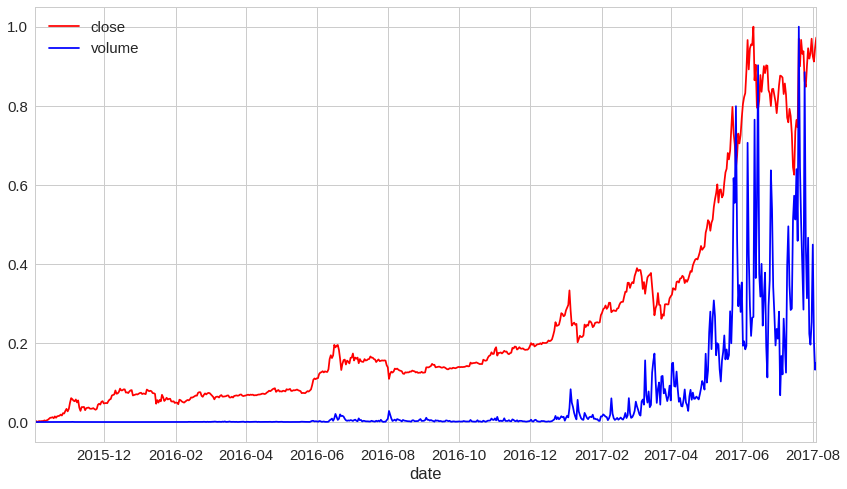

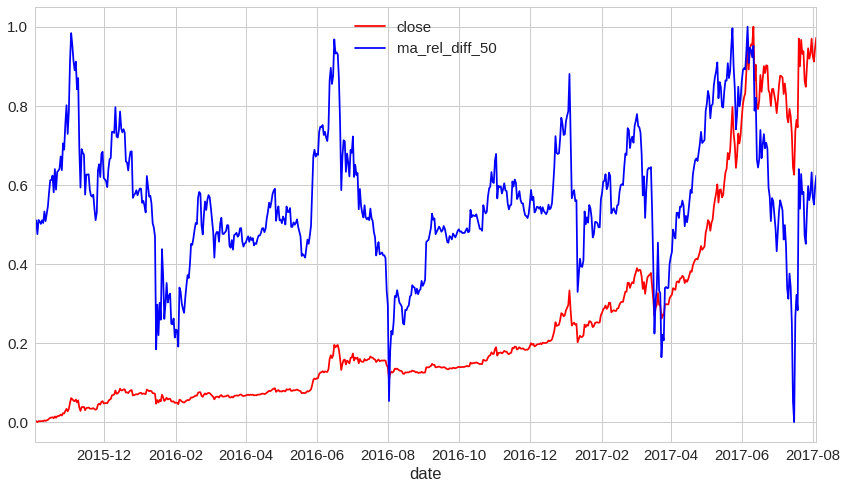

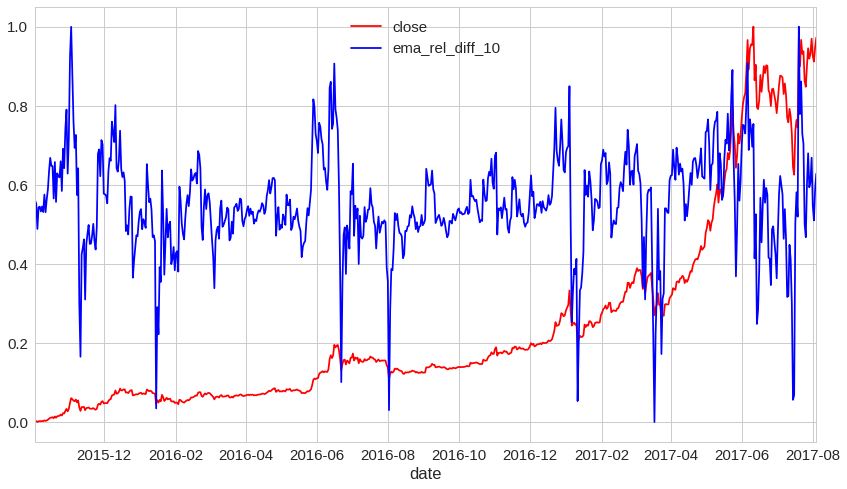

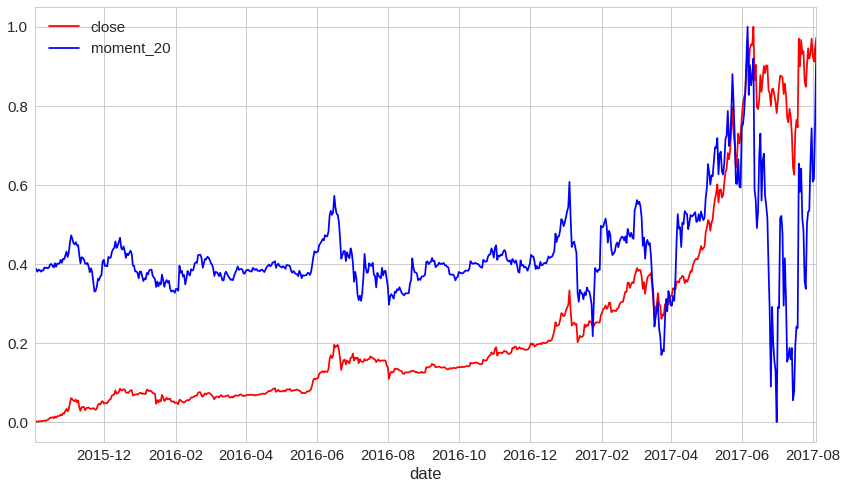

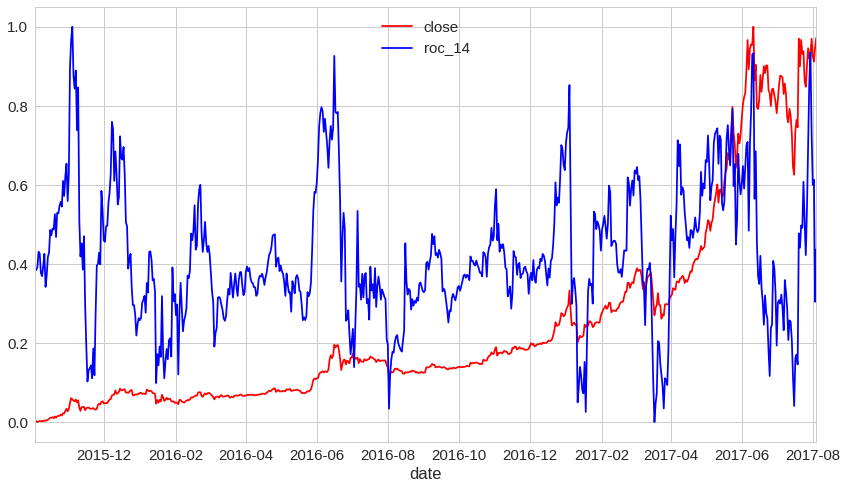

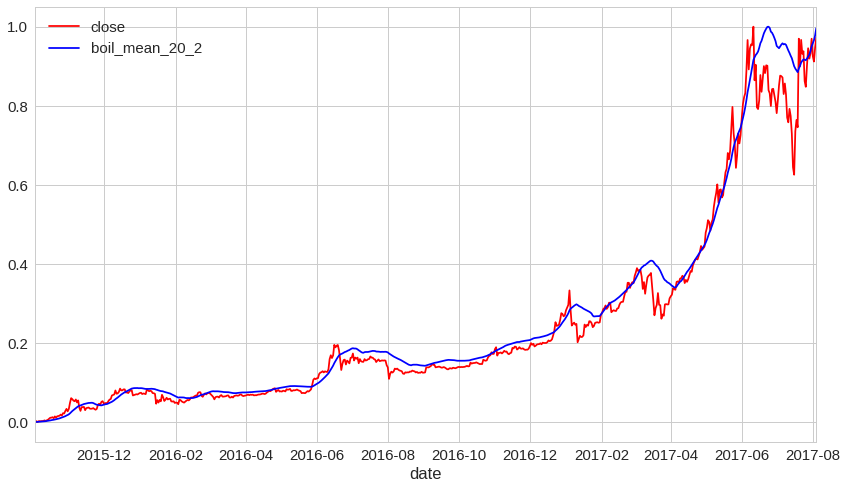

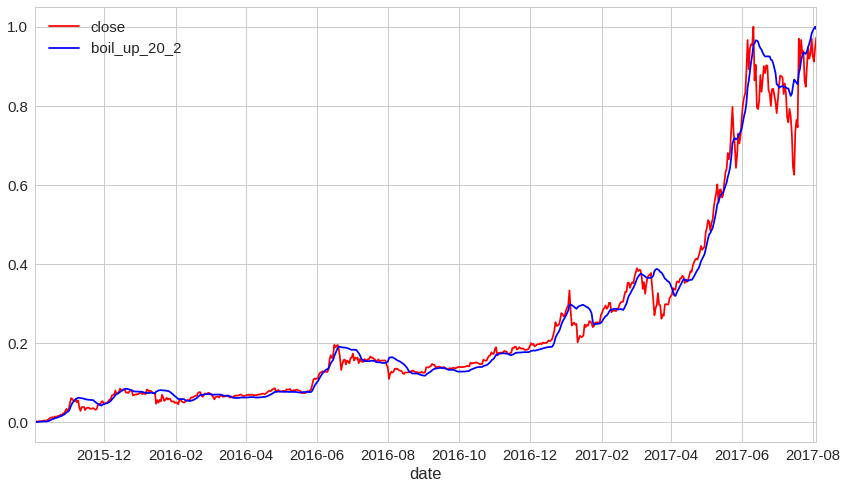

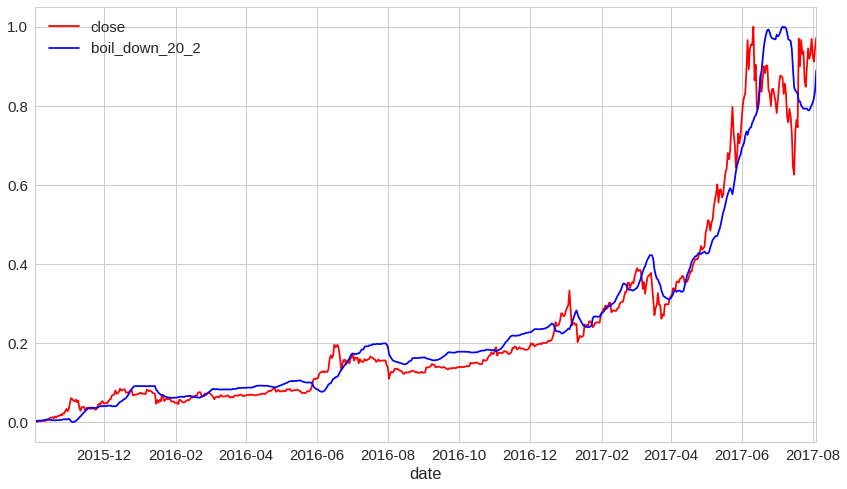

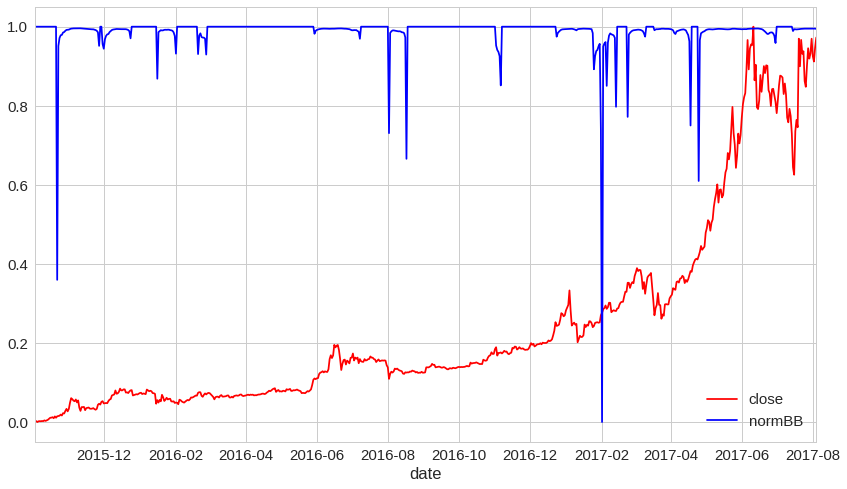

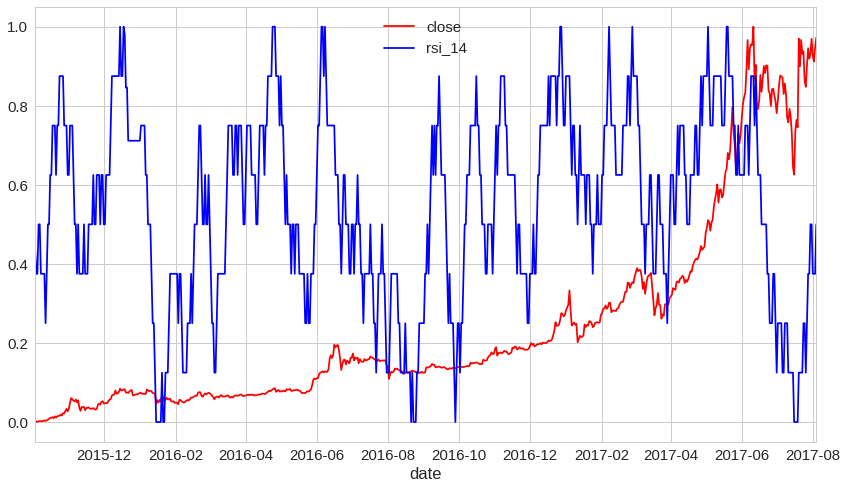

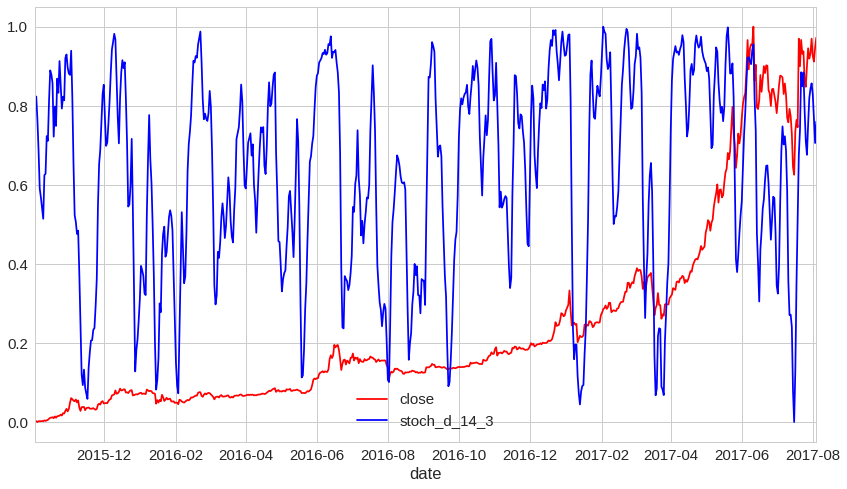

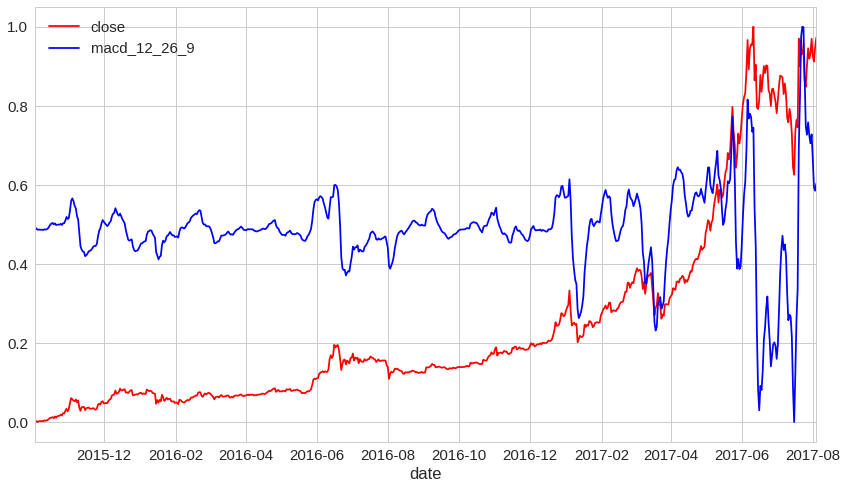

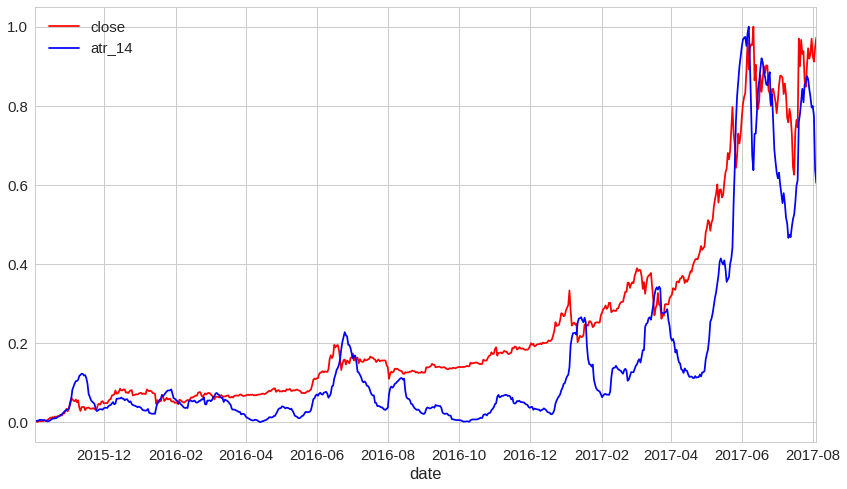

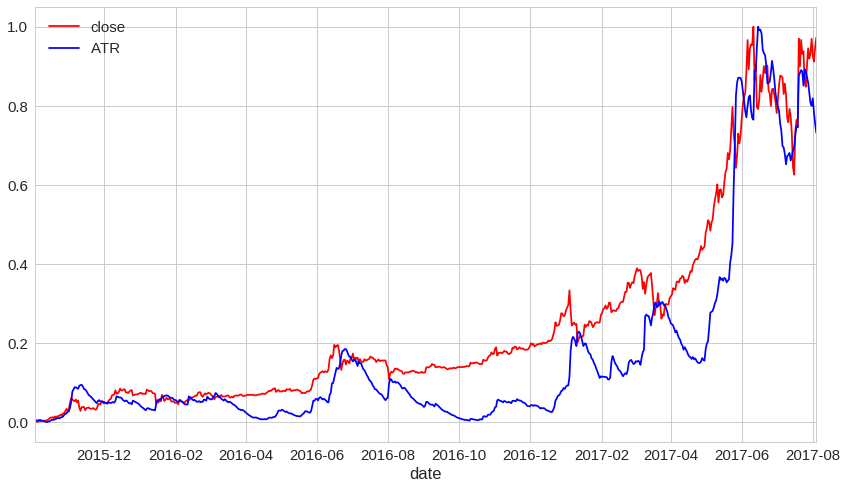

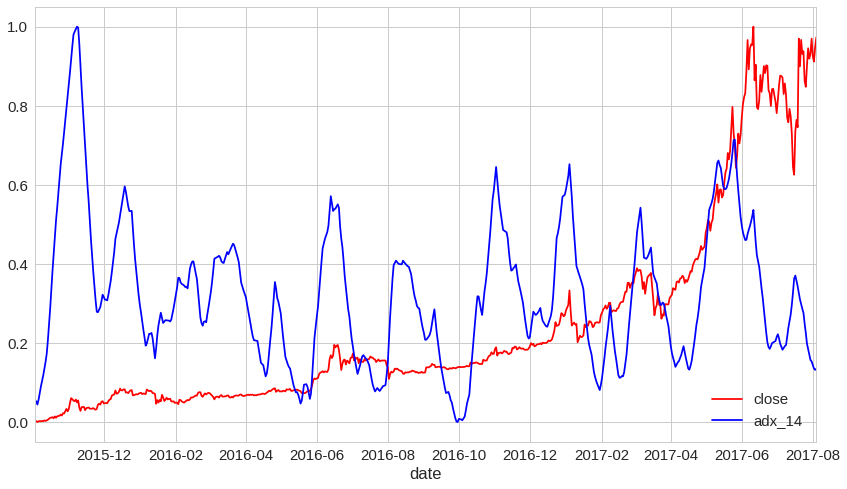

In [11]:
    sc_dataframe =  pd.DataFrame(sc,columns=df.columns, index=df.index)       

    for i in col:
        sc_dataframe[['close', i]].plot(color = ('red', 'blue'))

In [12]:
for i in col:
    featureValues = go.Scatter( x = sc_dataframe.index, y = sc_dataframe[ i].values, name = i)
    closeValues = go.Scatter( x = sc_dataframe.index, y = sc_dataframe.close.values, name = 'close')

    iplot([featureValues,closeValues])
    plt.show()

# Обучение

In [13]:
import get_data as get_data
import load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras import backend as K 

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [14]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model



In [48]:
# Прибыль моделек

def classifyALL(data):
    ## 2 - Buy Class, 1 - Sell Class, 0 - Hold Class
    label = []
    for i in range(len(data)):
        price = data[i:i+2]
        label.append(2 * (price[-1] > (price[0])) + 1 * (price[-1] < (price[0])))
    return np.array(label)

def calcDOXOD(data, labels):
    s = 0
    buffer = 0
    for i in range (1,len(data)):
        
        if (labels[i] == 2 and labels[i-1] != 2):
            s= s - data[i]
            buffer = 1
        if (labels[i] == 1 and buffer == 1):
            s= s + data[i]
            buffer = 0
        if labels[i] == 0:
            pass
        
    return s
      

In [81]:
def nextDayPrediction(typeBlockchain, stock):    
    
    plot = True
    plotHictory = False
    interactiveGrapth = True
    plotForTrain = False
    
    df = get_data.get_data_frame(typeBlockchain, stock)
    
    df.index  = df.date
    df = df[[ 'open','close','low','high','volume']]

    df = ma_rel_diff(df)
    df = ema_rel_diff(df)
    df = mom(df)
    df = roc(df)
    df = bbands(df)
    df = normalized_bbands(df)
    df = rsi(df)
    df = stochastics(df)
    df = macd(df)
    df = atr(df)
    df = adx(df)
    df = df.dropna()
    
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    all_df = df.copy()
    
    f_list = [['macd_12_26_9', 'stoch_d_14_3', 'roc_14'], ['moment_20', 'ema_rel_diff_10', 'ma_rel_diff_50'],\
              ['atr_14', 'moment_20'],['atr_14', 'moment_20','low', 'high'],
              ['roc_14', 'moment_20', 'ema_rel_diff_10' ], ['roc_14', 'rsi_14'], ['roc_14', 'rsi_14', 'macd_12_26_9']
             ]
    
    
    for features in f_list:
        
        x = all_df[features].copy()

        y = all_df['close'].copy()
        
        x[features] = x_scaler.fit_transform(x)
        NUM_FEATURES = x.shape[1]
        
        y = y_scaler.fit_transform(y.values.reshape(-1, 1))
        
        x['close'] = y
        
        X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)
        #X_train = X_train[:,:,-1]
        #X_train = X_train[:,:,-1]

        print (y_test.shape)
        model = build_model(input_shape=(WINDOW, NUM_FEATURES))

        print('START FIT MODEL...')
        print(features)
        print()
        start = time.time()

        history = History()
        history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=0,
                  callbacks=[history])

        #model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)
        end = time.time()

        print ('Learning time: ', end-start)

        today = time.strftime("_%d_%m_%Y")

        pathModel = "./model_" + str(features) + typeBlockchain + today +".h5"
        #pathModel = "../../models/model_low_high_USDT_BTC_03_08_2017.h5"
        #save_model(model, pathModel)

        model = load_model(pathModel)
        # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
        lastbatch = np.array(x[-WINDOW:])
        pred = model.predict([lastbatch.reshape(1,22, NUM_FEATURES)])
        pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

        # now we make dataframe and create row names in date

        lastDate =str(df.last_valid_index()).split('-')
        currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
        predictionDate = pd.date_range(currentData, periods=1)
        prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)

        print (prediction)



        if plotForTrain:

            trainPredict = model.predict(X_train)
            trainPredict = y_scaler.inverse_transform(trainPredict)
            prices = df.close.values.astype('float32')
            prices = prices.reshape(len(prices), 1)
            trainPredictPlot = np.empty_like(prices)
            trainPredictPlot[:, :] = np.nan
            trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
            ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

            iplot([ActualValues,TrainingValues])
            plt.show()

        if plot:
            trainPredict = model.predict(X_train)
            testPredict = model.predict(X_test)

            trainPredict = y_scaler.inverse_transform(trainPredict)
            trainY = y_scaler.inverse_transform([y_train])

            testPredict = y_scaler.inverse_transform(testPredict)
            testY = y_scaler.inverse_transform([y_test])

            trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
            print('Train Score: %.2f RMSE' % (trainScore))

            testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
            print('Test Score: %.2f RMSE' % (testScore))
           
        ############################ income ##############################3
            print ('income ACTUAL: ')
            print (testY)
            print (calcDOXOD(trainY.reshape(-1,), classifyALL(trainY.reshape(-1,)))    )

            print ('income PREDICTED: ')
            print (calcDOXOD(testPredict.reshape(-1,), classifyALL(testPredict.reshape(-1,)))    )   
        ############################ number TRUE predicted labels for TREND #######
            print ('% TRUE predicted labels for TREND:')
            quality = np.sum([classifyALL(y_test.reshape(-1,)) == classifyALL(testPredict.reshape(-1,))])
            print (quality/testPredict.shape[0])
            
            prices = df.close.values.astype('float32')
            prices = prices.reshape(len(prices), 1)
            trainPredictPlot = np.empty_like(prices)
            trainPredictPlot[:, :] = np.nan
            trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

            testPredictPlot = np.empty_like(prices)
            testPredictPlot[:, :] = np.nan
            testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

            plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
            plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
            plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
            plt.legend(loc='best')
            plt.show()

            interactiveGrapth = 1
            if interactiveGrapth:

                Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
                Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close
                Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close

                ActualValues = go.Scatter( x = df.index, y = Actual, name = 'ActualValues')
                TrainingValues = go.Scatter( x = df.index, y = Training, name = 'TrainingValues')
                TestingValues = go.Scatter( x = df.index, y = Testing, name = 'PredictedValues')

                iplot([ActualValues,TrainingValues, TestingValues])
                plt.show()

            if plotHictory:

                plt.plot(history.history['loss'], label = 'TrainLoss')
                plt.plot(history.history['val_loss'], label = 'TestLoss')
                plt.legend()
                plt.show()
            del model

            K.clear_session()
    
    return prediction

In [82]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex' ) 

(26,)
START FIT MODEL...
['macd_12_26_9', 'stoch_d_14_3', 'roc_14']

Learning time:  4.76837158203125e-07


ValueError: Error when checking : expected lstm_1_input to have shape (None, 22, 3) but got array with shape (1, 22, 4)